# Deepfake Detection: Model Training and Evaluation
## Team Quarks (Ali & Belal)
## Objective
The objective of this notebook is to employ machine learning models to assess the predictive power of the facial landmark variance feature, which was identified as a potential indicator during our EDA.
## Data Description
The dataset consists of facial landmark data extracted from a series of videos. Each entry in the dataset represents a video and includes the variance of facial landmark velocities in the X and Y axes, as well as the percentage of frames in which a face was successfully detected.

In [1]:
import os
import pandas as pd
import json

def create_dataframe_from_json(directory):
    data = []
    errors = []

    # List all files in the given directory
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)

            try:
                # Read the JSON file
                with open(file_path, 'r') as file:
                    json_data = json.load(file)
                    
                # Start the dictionary with the video name
                video_data = {'video_name': filename.replace('.json', '')}
                # Update this dictionary with the overall_features
                video_data.update(json_data.get("overall_features", {}))

                data.append(video_data)

            except Exception as e:
                errors.append((filename, str(e)))

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Rename columns to be more descriptive
    column_renaming = {
        'chin_xvel_var': 'Chin X-Axis Velocity Variance',
        'chin_yvel_var': 'Chin Y-Axis Velocity Variance',
        'left_eyebrow_xvel_var': 'Left Eyebrow X-Axis Velocity Variance',
        'left_eyebrow_yvel_var': 'Left Eyebrow Y-Axis Velocity Variance',
        'right_eyebrow_xvel_var': 'Right Eyebrow X-Axis Velocity Variance',
        'right_eyebrow_yvel_var': 'Right Eyebrow Y-Axis Velocity Variance',
        'nose_bridge_xvel_var': 'Nose Bridge X-Axis Velocity Variance',
        'nose_bridge_yvel_var': 'Nose Bridge Y-Axis Velocity Variance',
        'nose_tip_xvel_var': 'Nose Tip X-Axis Velocity Variance',
        'nose_tip_yvel_var': 'Nose Tip Y-Axis Velocity Variance',
        'left_eye_xvel_var': 'Left Eye X-Axis Velocity Variance',
        'left_eye_yvel_var': 'Left Eye Y-Axis Velocity Variance',
        'right_eye_xvel_var': 'Right Eye X-Axis Velocity Variance',
        'right_eye_yvel_var': 'Right Eye Y-Axis Velocity Variance',
        'top_lip_xvel_var': 'Top Lip X-Axis Velocity Variance',
        'top_lip_yvel_var': 'Top Lip Y-Axis Velocity Variance',
        'bottom_lip_xvel_var': 'Bottom Lip X-Axis Velocity Variance',
        'bottom_lip_yvel_var': 'Bottom Lip Y-Axis Velocity Variance',
        'face_detection_percentage': 'Face Detection Percentage',
        'label': 'Video Authenticity Label'
    }
    df = df.rename(columns=column_renaming)

    return df, errors

directory_path = "/data1/belalm/Capstone/data/landmarks"
df, errors = create_dataframe_from_json(directory_path)

print(df) 

if errors:
    print("Errors encountered:")
    for error in errors:
        print(error)


       video_name  Chin X-Axis Velocity Variance  \
0      hyhjfdxqxy                       0.495092   
1      lcxsmhpfbm                       0.484788   
2      fahbidqhcx                            NaN   
3      mrmaimxhjn                       2.400303   
4      yygjogokma                       4.484175   
...           ...                            ...   
22880  nwgbsdkryv                       4.956775   
22881  igvyqqqxfj                       9.614184   
22882  kverutwcbw                       0.661452   
22883  hyzeitilgy                      62.350724   
22884  mvfeurfoyq                       0.531911   

       Chin Y-Axis Velocity Variance  Left Eyebrow X-Axis Velocity Variance  \
0                           2.280703                               0.916649   
1                           1.515197                               1.699149   
2                                NaN                                    NaN   
3                           3.842056                       

## Model Testing
In this section, we load the preprocessed data and implement several machine learning models to assess their performance.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

X = df.drop(['video_name', 'Video Authenticity Label'], axis=1)
y = df['Video Authenticity Label'].map({'FAKE': 0, 'REAL': 1})  # Convert labels to binary

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values using the mean of each column
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale the features to be used by SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)


## Model Selection Rationale
### Logistic Regression, SVM, Random Forest, Gradient Boosting
- Chosen for their efficacy in binary classification tasks.
- **Assumptions and Limitations:** Each model's assumptions are evaluated against the data characteristics.
- **Model Comparisons:** Theoretical and practical aspects are compared.

## Cross-Validation Strategy
### 5-Fold Cross-Validation
- Ensures robust performance estimation.
- Results imply model generalizability.

## Train a Logistic Regression model

In [3]:
# Initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)

# Train the model using the imputed and scaled training data
logistic_model.fit(X_train_scaled, y_train)

# Predict on the imputed and scaled test set
logistic_predictions = logistic_model.predict(X_test_scaled)

# Evaluate the Logistic Regression model
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
print(f"Logistic Regression Accuracy: {logistic_accuracy}")
print(classification_report(y_test, logistic_predictions))


Logistic Regression Accuracy: 0.539654795717719
              precision    recall  f1-score   support

           0       0.59      0.24      0.34      2268
           1       0.53      0.84      0.65      2309

    accuracy                           0.54      4577
   macro avg       0.56      0.54      0.49      4577
weighted avg       0.56      0.54      0.49      4577



In [4]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation for Logistic Regression
logistic_cv_scores = cross_val_score(logistic_model, X_train_scaled, y_train, cv=5)
print(f"Logistic Regression CV scores: {logistic_cv_scores}")
print(f"Logistic Regression CV mean score: {logistic_cv_scores.mean()}")

Logistic Regression CV scores: [0.52484981 0.5324959  0.52839978 0.54028954 0.53182191]
Logistic Regression CV mean score: 0.5315713878451644


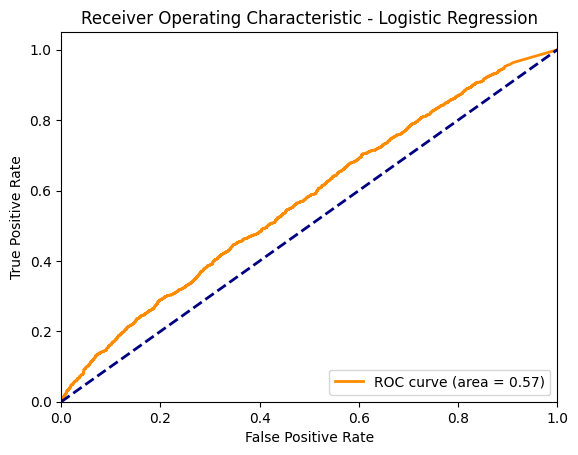

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the probabilities of each class
logistic_probs = logistic_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve and ROC AUC
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, logistic_probs)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Plot ROC curve
plt.figure()
plt.plot(fpr_logistic, tpr_logistic, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_logistic)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


In [19]:
# Logistic Regression - In-Sample and Out-of-Sample Results
logistic_in_sample_preds = logistic_model.predict(X_train_scaled)
logistic_in_sample_accuracy = accuracy_score(y_train, logistic_in_sample_preds)

print(f"Logistic Regression In-sample Accuracy: {logistic_in_sample_accuracy}")
print(f"Logistic Regression Out-of-Sample Accuracy: {logistic_accuracy}")

Logistic Regression In-sample Accuracy: 0.5317347607603233
Logistic Regression Out-of-Sample Accuracy: 0.539654795717719


## Train a Random Forest Classifier

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model on the imputed data (no need to scale for tree-based models)
rf_model.fit(X_train_imputed, y_train)

# Predict on the imputed test set
rf_predictions = rf_model.predict(X_test_imputed)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")
print(classification_report(y_test, rf_predictions))

Random Forest Accuracy: 0.6368800524360935
              precision    recall  f1-score   support

           0       0.63      0.66      0.64      2268
           1       0.65      0.61      0.63      2309

    accuracy                           0.64      4577
   macro avg       0.64      0.64      0.64      4577
weighted avg       0.64      0.64      0.64      4577



In [7]:
# Perform 5-fold cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, X_train_imputed, y_train, cv=5)
print(f"Random Forest CV scores: {rf_cv_scores}")
print(f"Random Forest CV mean score: {rf_cv_scores.mean()}")

Random Forest CV scores: [0.63271436 0.63353359 0.65374113 0.63152144 0.64190112]
Random Forest CV mean score: 0.6386823278297182


In [21]:
# Random Forest - In-Sample and Out-of-Sample Results
rf_in_sample_preds = rf_model.predict(X_train_scaled)
rf_in_sample_accuracy = accuracy_score(y_train, rf_in_sample_preds)

print(f"Random Forest In-sample Accuracy: {rf_in_sample_accuracy}")
print(f"Random Forest Out-of-Sample Accuracy: {rf_accuracy}")


Random Forest In-sample Accuracy: 0.5037142232903649
Random Forest Out-of-Sample Accuracy: 0.6368800524360935


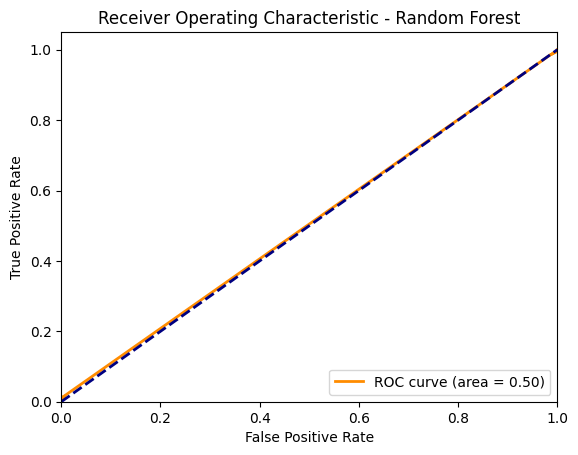

In [22]:
# Calculate the probabilities of each class
rf_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve and ROC AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc="lower right")
plt.show()


## Train a Gradient Boosting Classifier

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the Gradient Boosting model on the imputed data
gb_model.fit(X_train_imputed, y_train)

# Predict on the imputed test set
gb_predictions = gb_model.predict(X_test_imputed)

# Evaluate the Gradient Boosting model
gb_accuracy = accuracy_score(y_test, gb_predictions)
print(f"Gradient Boosting Accuracy: {gb_accuracy}")
print(classification_report(y_test, gb_predictions))

Gradient Boosting Accuracy: 0.6143762289709417
              precision    recall  f1-score   support

           0       0.60      0.65      0.63      2268
           1       0.63      0.58      0.60      2309

    accuracy                           0.61      4577
   macro avg       0.62      0.61      0.61      4577
weighted avg       0.62      0.61      0.61      4577



In [9]:
# Perform 5-fold cross-validation for Gradient Boosting
gb_cv_scores = cross_val_score(gb_model, X_train_imputed, y_train, cv=5)
print(f"Gradient Boosting CV scores: {gb_cv_scores}")
print(f"Gradient Boosting CV mean score: {gb_cv_scores.mean()}")

Gradient Boosting CV scores: [0.60404151 0.61441835 0.63080284 0.61485933 0.6058454 ]
Gradient Boosting CV mean score: 0.6139934846928172


In [23]:
# Gradient Boosting - In-Sample and Out-of-Sample Results
gb_in_sample_preds = gb_model.predict(X_train_scaled)
gb_in_sample_accuracy = accuracy_score(y_train, gb_in_sample_preds)

print(f"Gradient Boosting In-sample Accuracy: {gb_in_sample_accuracy}")
print(f"Gradient Boosting Out-of-Sample Accuracy: {gb_accuracy}")


Gradient Boosting In-sample Accuracy: 0.5022940790911077
Gradient Boosting Out-of-Sample Accuracy: 0.6143762289709417


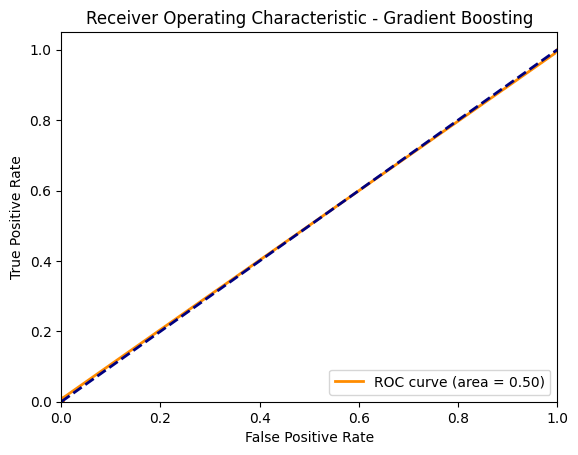

In [27]:
# Calculate the probabilities of each class
gb_probs = gb_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve and ROC AUC
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_probs)
roc_auc_gb = auc(fpr_gb, tpr_gb)

# Plot ROC curve
plt.figure()
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()


### Learning Curve

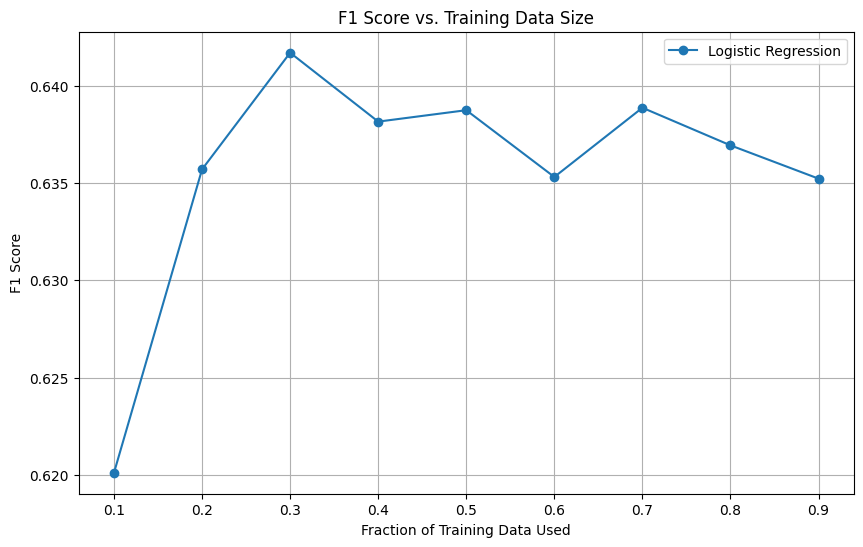

In [30]:
from sklearn.metrics import f1_score
import numpy as np

def calculate_f1_scores(model, X, y, increments, imputer, scaler):
    """
    Trains the model on various fractions of the training data and calculates F1 scores.

    :param model: The machine learning model to be trained.
    :param X: Feature data.
    :param y: Target data.
    :param increments: List of fractions of the dataset to use for training.
    :param imputer: Imputer object for handling missing values.
    :param scaler: Scaler object for feature scaling.
    :return: A list of F1 scores corresponding to each fraction.
    """
    f1_scores = []
    for frac in increments:
        # Splitting the data
        X_sample, _, y_sample, _ = train_test_split(X, y, train_size=frac, random_state=42)
        
        # Impute and scale the sample
        X_sample_imputed = imputer.fit_transform(X_sample)
        X_sample_scaled = scaler.fit_transform(X_sample_imputed)
        
        # Training the model
        model.fit(X_sample_scaled, y_sample)
        
        # Making predictions and calculating F1 score
        predictions = model.predict(X_sample_scaled)
        score = f1_score(y_sample, predictions)
        f1_scores.append(score)
    
    return f1_scores
fractions = np.linspace(0.1, 0.9, 9)  # Adjusted fractions, excluding 1.0
f1_scores_logistic = calculate_f1_scores(LogisticRegression(max_iter=1000), X_train, y_train, fractions, imputer, scaler)

plt.figure(figsize=(10, 6))
plt.plot(fractions, f1_scores_logistic, marker='o', label='Logistic Regression')
plt.title('F1 Score vs. Training Data Size')
plt.xlabel('Fraction of Training Data Used')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()
